In [1]:
import os
import sys
import csv
import argparse
import operator
import cPickle as pickle
import re
from mpi4py import MPI
from itertools import chain
from collections import defaultdict
from collections import Counter
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import datetime
import time

from numods.usefuns import AinB
from numods.numio import getsignaldf, getmetadf, gettimedf, getalldata, getsigdat
from numods.sigstats import sigdat_show, location_stats, freq_stats, numofsig_stats, siglen_stats, allsig_stats
from numods.proctime import givenanons, givetimedseq

In [2]:
filename = "/Users/digvijaysingh/Desktop/JHMIJOB/database/mimic3wdb/matched_num/p00/p000020/p000020-2183-04-28-17-47n"

In [3]:
record = wfdb.io.rdrecord(

                record_name = filename,
                sampfrom = 0,
                sampto = "end",
                channels = "all"

                ).__dict__

In [4]:
print record.keys()
print record["sig_name"]

['base_time', 'base_counter', 'sig_name', 'file_name', 'init_value', 'base_date', 'block_size', 'counter_freq', 'baseline', 'adc_gain', 'fmt', 'byte_offset', 'comments', 'units', 'sig_len', 'e_p_signal', 'fs', 'record_name', 'n_sig', 'samps_per_frame', 'adc_res', 'd_signal', 'skew', 'base_datetime', 'checksum', 'p_signal', 'adc_zero', 'e_d_signal']
['HR', 'ABPSys', 'ABPDias', 'ABPMean', 'PAPSys', 'PAPDias', 'PAPMean', 'CVP', 'PULSE', 'RESP', 'SpO2', 'NBPSys', 'NBPDias', 'NBPMean', 'CO']


In [5]:
for key in record.keys():
    print key, ":", record[key]

base_time : 17:47:59.486000
base_counter : None
sig_name : ['HR', 'ABPSys', 'ABPDias', 'ABPMean', 'PAPSys', 'PAPDias', 'PAPMean', 'CVP', 'PULSE', 'RESP', 'SpO2', 'NBPSys', 'NBPDias', 'NBPMean', 'CO']
file_name : ['3544749n.dat', '3544749n.dat', '3544749n.dat', '3544749n.dat', '3544749n.dat', '3544749n.dat', '3544749n.dat', '3544749n.dat', '3544749n.dat', '3544749n.dat', '3544749n.dat', '3544749n.dat', '3544749n.dat', '3544749n.dat', '3544749n.dat']
init_value : [986, 1157, 542, 729, 358, 192, 262, 125, 777, 98, 1000, -32768, -32768, -32768, 0]
base_date : 2183-04-28
block_size : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
counter_freq : 125.0
baseline : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
adc_gain : [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0, 100.0]
fmt : ['16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16', '16']
byte_offset : [None, None, None, None, None, None, None, None, None, None, None, None, None, 

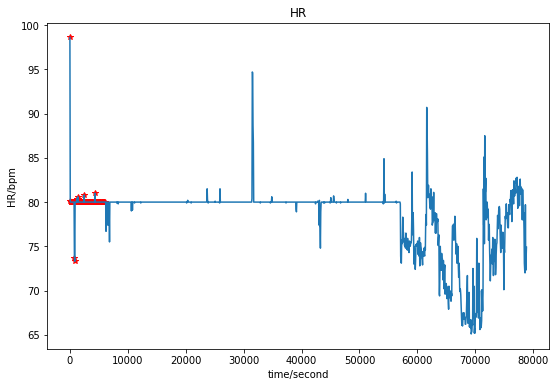

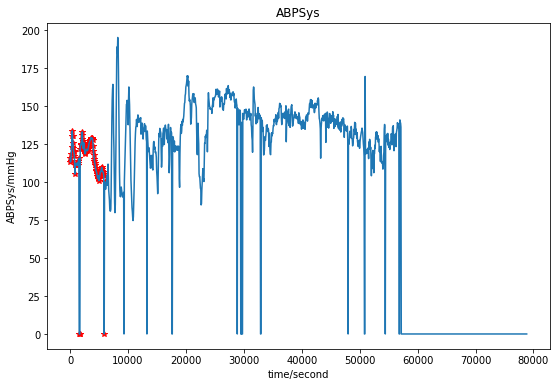

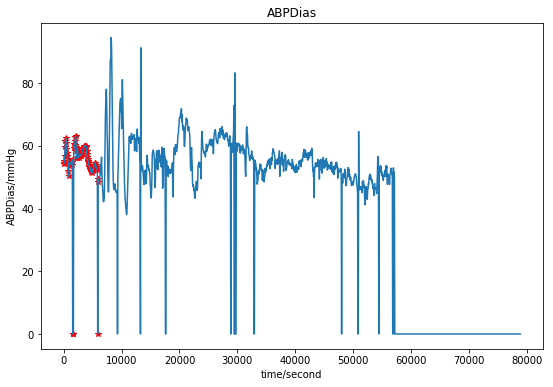

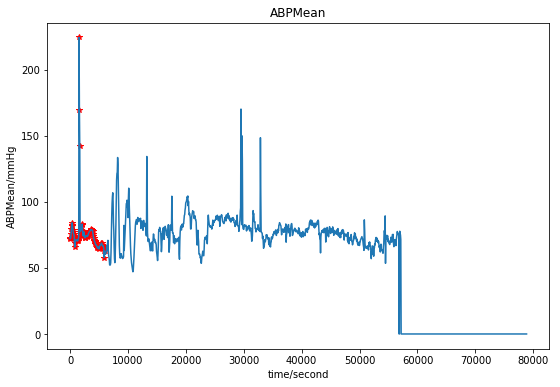

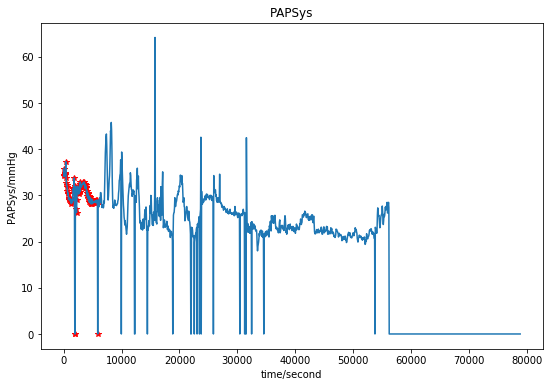

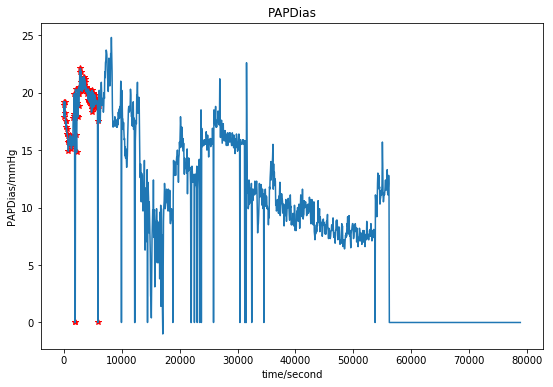

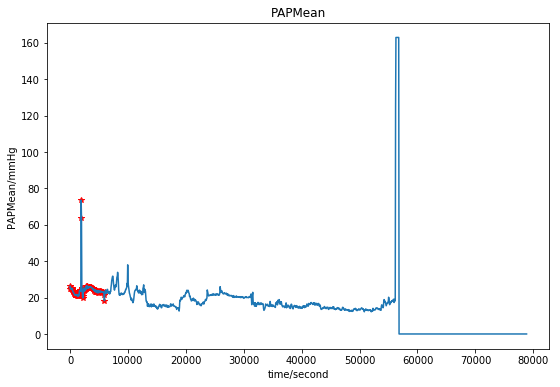

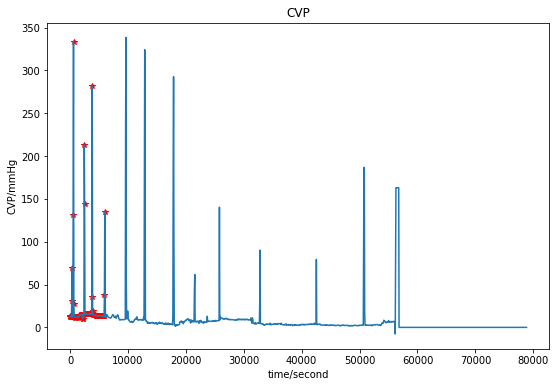

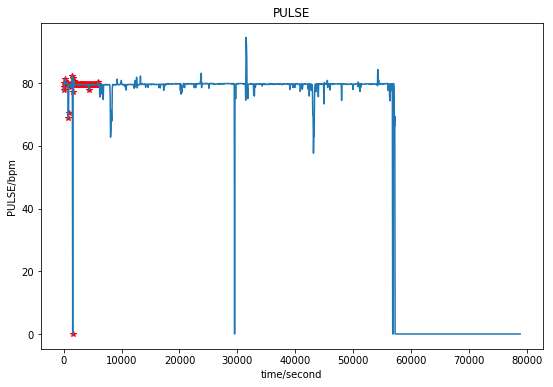

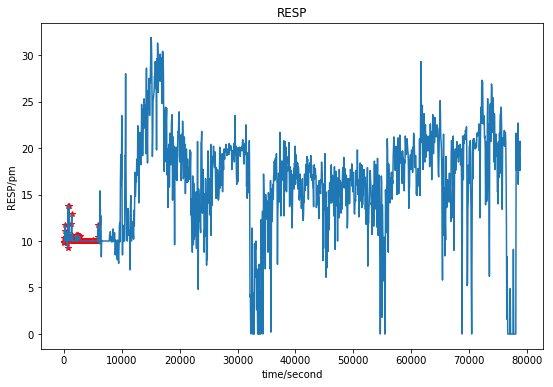

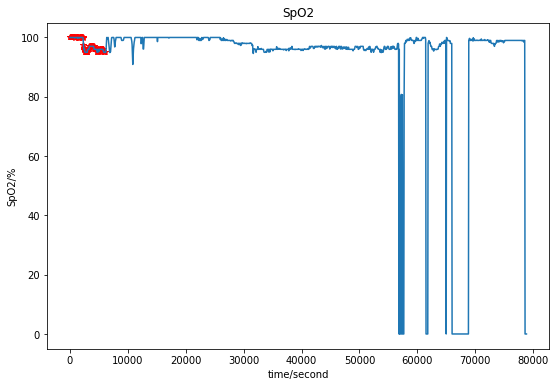

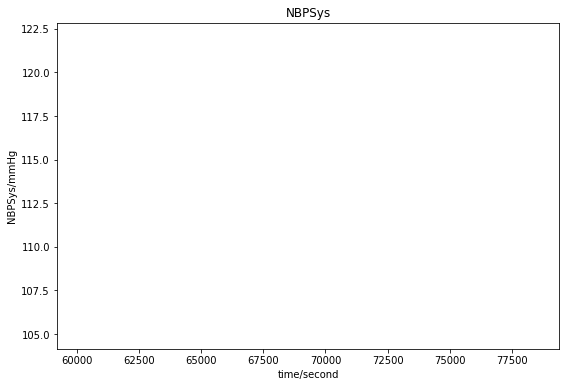

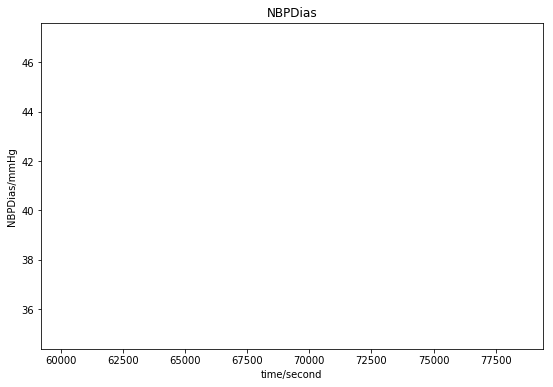

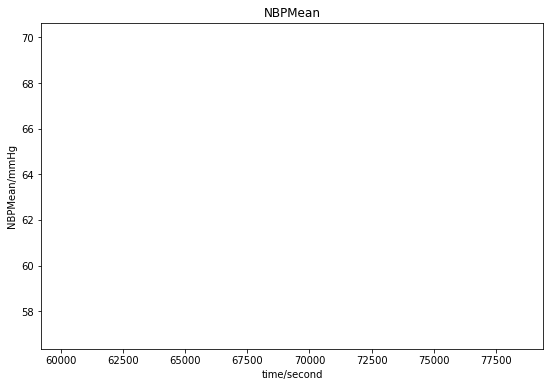

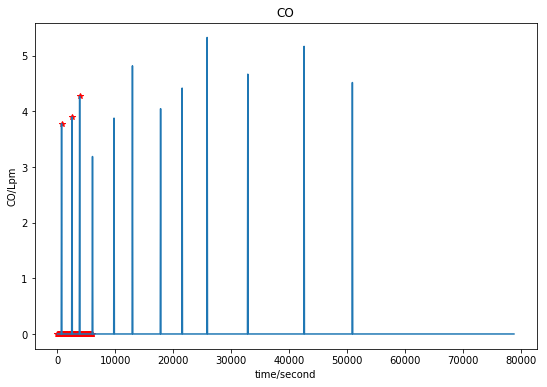

In [6]:
for sig in record["sig_name"]:
    
    i = record["sig_name"].index(sig)
    
    wfdb.plot.plot_items(
        
        signal = record["p_signal"][:,i], # the signal you want to plot
        ann_samp = [np.array(range(101))], # the part of the signal (time points) you want to annotate
        fs = record["fs"], # used to calculate time intervals if time_units is not ‘samples’, also required for plotting ecg grids
        time_units = "seconds", #  ‘samples’, ‘seconds’, ‘minutes’, and ‘hours’
        sig_name =[record["sig_name"][i]], # list of signal names to plot
        sig_units = [record["units"][i]], # list of signal units to plot corresponding to 'sig_name' list
        title = record["sig_name"][i], # title of the plot
        #ecg_grids = "all", # list of channel numbers to plot ecg grids, 'all' an option, used only if units are 'uV', 'mV' or 'V'
        figsize = (9,6), # size of figure
        return_fig = False, # whether to return figure as object or not
        
    )

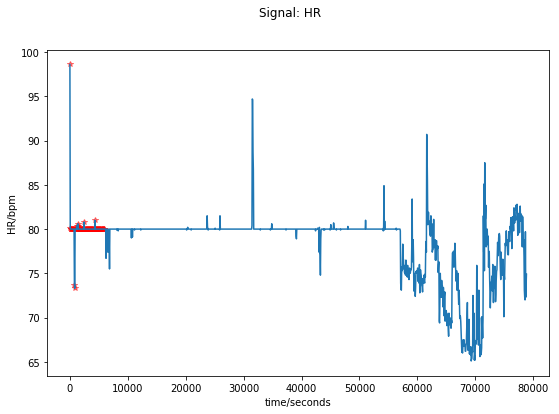

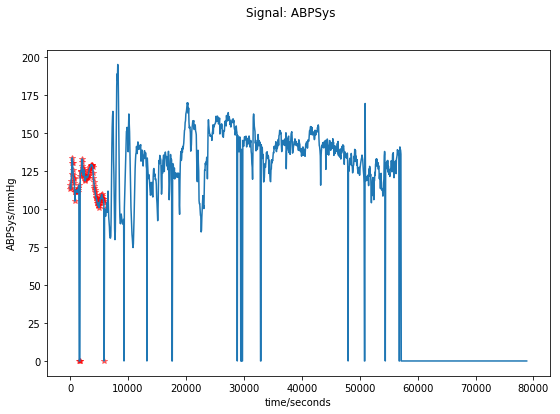

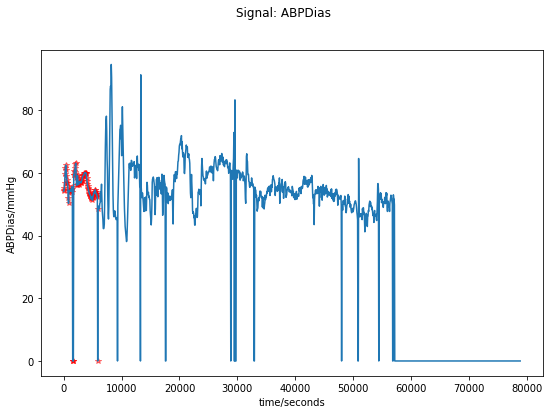

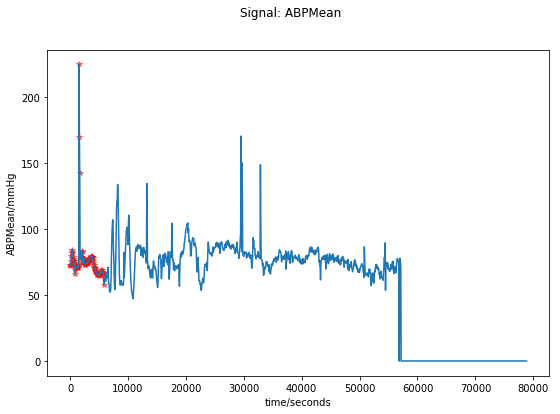

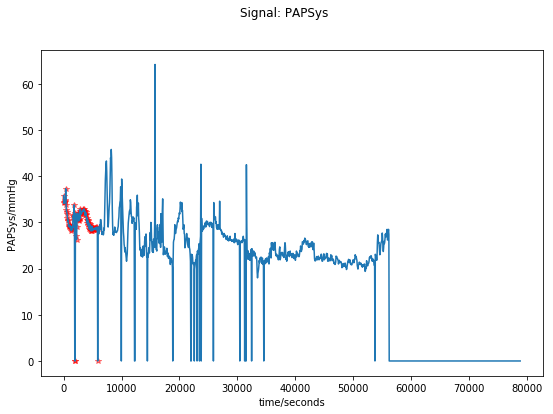

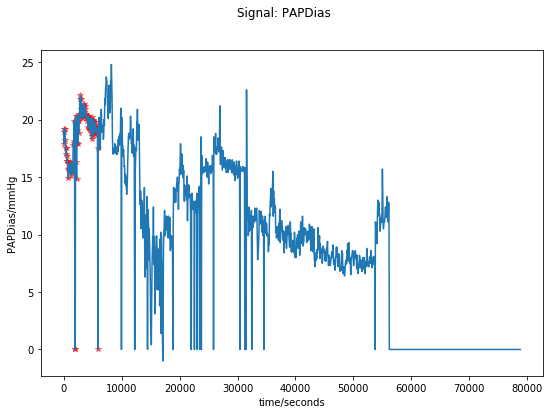

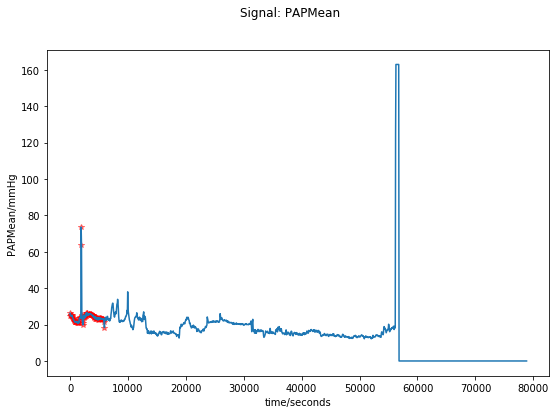

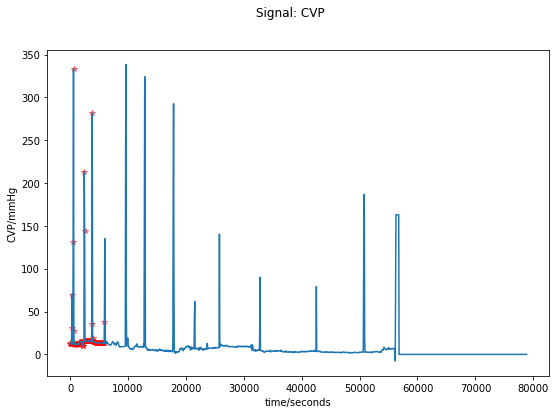

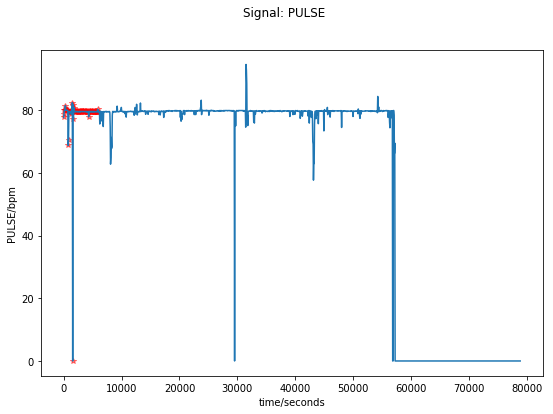

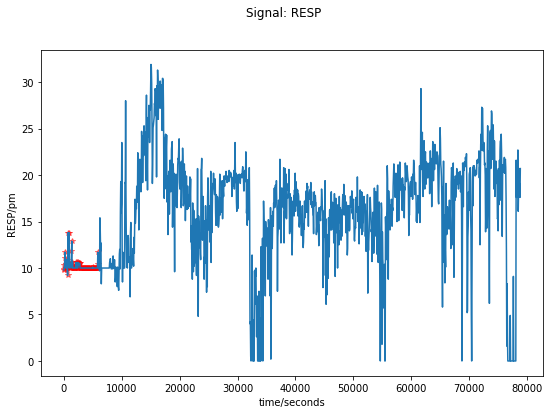

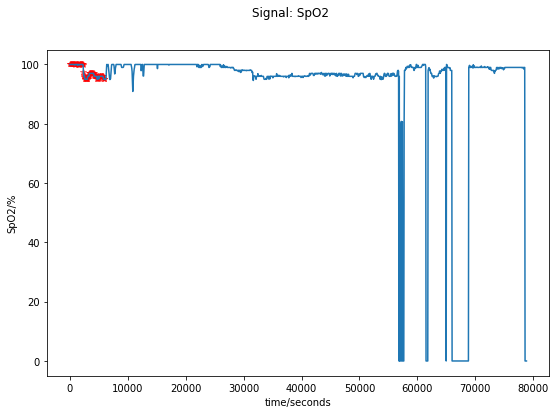

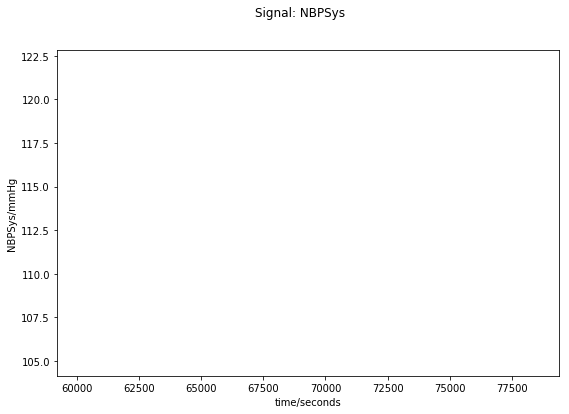

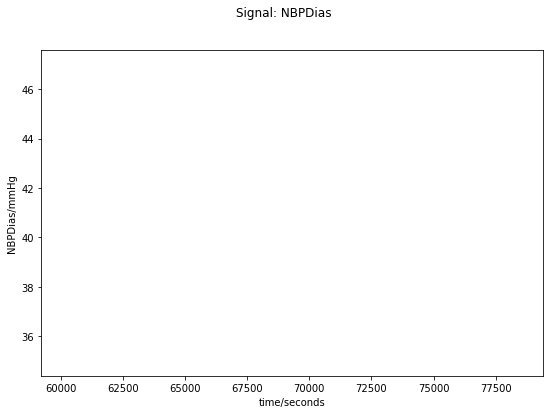

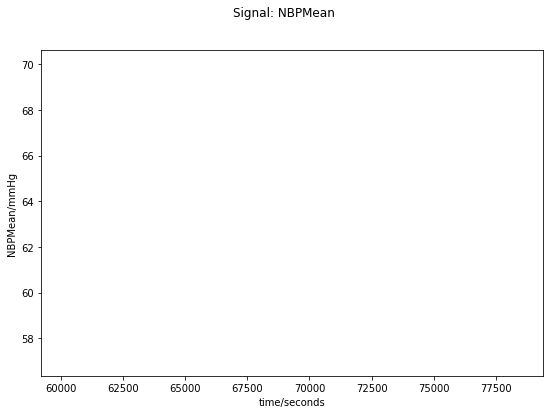

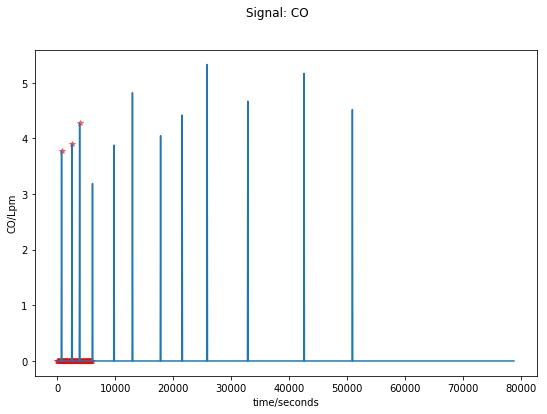

In [7]:
downsampling = {"samples":1.0, "seconds":float(record["fs"]), "minutes":record["fs"] * 60.0, "hours":record["fs"]*60.0*60.0}

time_unit = "seconds"
ann_index = (0,100)
time = [x / downsampling[time_unit] for x in range(record["sig_len"])]
time_ann = [x / downsampling[time_unit] for x in range(record["sig_len"])[ann_index[0]:ann_index[1]]]

for sig in record["sig_name"]:
    
    i = record["sig_name"].index(sig)

    fig = plt.figure(figsize=(9,6))

    plt.plot(time_ann, record["p_signal"][ann_index[0]:ann_index[1],i], "*r", alpha=0.5)
    plt.plot(time, record["p_signal"][:,i])
    plt.xlabel("time/" + time_unit)
    plt.ylabel(record["sig_name"][i] + "/" + record["units"][i])
    fig.suptitle("Signal: " + record["sig_name"][i], fontsize=12)

    plt.show()

In [8]:
def plotwf(signal_name, dfs, record_name, time_unit="samples", useconv=False, index=None, ann_index=None, title_val=None, star=False, fig_size=(20,5)):
    
    if record_name not in dfs[1].index or record_name not in dfs[2].index:
        print("Invalid record id.")
        return
    
    signal = dfs[2].loc[record_name]["sequence"]
    signal_unit = dfs[1].loc[record_name]["unit"]
    fs = dfs[1].loc[record_name]["sampling_frequency"]
    
    downsampling = {"samples":1.0, "seconds":fs, "minutes":fs * 60.0, "hours":fs*60.0*60.0}
    
    time = np.arange(signal.size) / downsampling[time_unit]

    if useconv:
        time, signal = givetimedseq(signal_name, record_name, time_unit)
        time = list(time)
        signal = list(signal)
        if index is not None:
            if len(time)> index[1] - index[0] and index[1] < len(time):
                start = 0
                end = 0
                
                for t in time:
                    if t > index[0]:
                        start = time.index(t) - 1
                        break
                for t in time:
                    if t < index[1]:
                        end = time.index(t)
                
                time = time[start:end]
                signal = signal[start:end]
            else: print("Sequence not available.")
        
    fig = plt.figure(figsize=fig_size)

#     flag = False
#     if ann_index is not None:
#         if ann_index[0] >= 0 and ann_index[1] >= 0 and ann_index[0] < signal.size and ann_index[1] < signal.size and ann_index[0] <= ann_index[1]:
#             time_ann = np.arange(signal.size)[ann_index[0]:ann_index[1]] / downsampling[time_unit]
#             if star: plt.plot(time_ann, signal[ann_index[0]:ann_index[1]], "*r", alpha=0.5)
#             else: plt.plot(time_ann, signal[ann_index[0]:ann_index[1]], c="orange")
#         else: 
#             flag = True
    plt.plot(time, signal, c="steelblue")
    
    plt.xlabel("time/" + time_unit)
    plt.ylabel(signal_name + "/" + signal_unit)
    if title_val is None: title = "Signal: " +  signal_name
    else: title = title_val + "\nSignal: " +  signal_name
    fig.suptitle(title, fontsize=12)
    
    plt.show()
#     if flag: print("Annotation indices out of range. Plotting without annotating.")

In [9]:
def mplotwf(signal_list, dfs, record_name, time_unit="samples", useconv=False, index=None, ann_index=None, title_val=None, star=False, fig_size=(20,5)):
    
    if AinB(signal_list, dfs[1].loc[record_name]["present_signals"], "any"):
        plot_signals = list(set(signal_list) & set(dfs[1].loc[record_name]["present_signals"]))
    else:
        print("No signal present.")
        return

    color = plt.cm.rainbow(np.linspace(0,1,len(plot_signals)))
    
    fig = plt.figure(figsize=fig_size)
    
    if title_val is None: title = "Record: " +  record_name
    else: title = title_val + "\nRecord: " +  record_name
    fig.suptitle(title, fontsize=12)
    
    units = ""
    
    for signal_name in plot_signals:
        
        signal = gettimedf(signal_name).loc[record_name]["sequence"]
        signal_unit = getmetadf(signal_name).loc[record_name]["unit"]
        units = units + "/" + signal_name + " (" + signal_unit + ")"
        fs = getmetadf(signal_name).loc[record_name]["sampling_frequency"]

        downsampling = {"samples":1.0, "seconds":fs, "minutes":fs * 60.0, "hours":fs*60.0*60.0}

        time = np.arange(signal.size) / downsampling[time_unit]

        if useconv:
            time, signal = givetimedseq(signal_name, record_name, time_unit)
            time = list(time)
            signal = list(signal)
            if index is not None:
                if len(time)> index[1] - index[0] and index[1] < len(time):
                    start = 0
                    end = 0

                    for t in time:
                        if t > index[0]:
                            start = time.index(t) - 1
                            break
                    for t in time:
                        if t < index[1]:
                            end = time.index(t)

                    time = time[start:end]
                    signal = signal[start:end]
                else: print("Sequence not available.")
        
#         flag = False
#         if ann_index is not None:
#             if ann_index[0] >= 0 and ann_index[1] >= 0 and ann_index[0] < signal.size and ann_index[1] < signal.size and ann_index[0] <= ann_index[1]:
#                 time_ann = np.arange(signal.size)[ann_index[0]:ann_index[1]] / downsampling[time_unit]
#                 if star: plt.plot(time_ann, signal[ann_index[0]:ann_index[1]], "*r", alpha=0.5)
#                 else: plt.plot(time_ann, signal[ann_index[0]:ann_index[1]], c="orange")
#             else: 
#                 flag = True
        plt.plot(time, signal, c=color[plot_signals.index(signal_name)], label=signal_name)

    plt.xlabel("time/" + time_unit)
    plt.ylabel(units)
    plt.legend(loc=1, fontsize=6)
#     if flag: print("Annotation indices out of range. Plotting without annotating.")
    plt.show()

In [10]:
signal_list = ["abpmean", "abpdias", "abpsys", "nbpmean", "nbpdias", "nbpsys", "hr", "papmean", "cvp", "spo2"]